# Example: Fine-tune NPI ResNet-1D on real data example and propagate EnsCGP ensemble

This notebook demonstrates a **typical real-data adaptation loop** for the Neuro-Physical Inverter (NPI):
1. Load a **pretrained residual network** trained on synthetic data (`best_npi_model_synthetic.pt`).
2. Load normalization statistics (`input_mean/std`, `label_mean/std`).
3. Load **EnsCGP outputs** for a real station/example (`gv161`) from `outputs/enscgp/gv161`.
4. Fine-tune the network on real data using a **physics misfit loss** + smoothness/smallness penalties.
5. Propagate the full **EnsCGP ensemble** through the fine-tuned network and save summary plots.

## Recommended repo storage for pretrained artifacts
- `models/npi/` for neural checkpoints and stats:
  - `models/npi/best_npi_model_synthetic.pt`
  - `models/npi/input_mean.pth`, `models/npi/input_std.pth`
  - `models/npi/label_mean.pth`, `models/npi/label_std.pth`
- Outputs produced by this notebook:
  - `outputs/npi/gv161/` (fine-tuned checkpoint, refined ensemble, plots)


In [1]:
# --- Imports & environment ---
from __future__ import annotations

import os
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch: 2.10.0+cu128
cuda available: False


In [2]:
# --- Resolve paths (assumes this notebook lives in <repo>/examples/) ---
HERE = Path.cwd()
# If you're running from within examples/, repo root is one level up.
# If not, adjust accordingly.
REPO_ROOT = (HERE / "..").resolve() if (HERE / ".." / "src").exists() else HERE.resolve()
print("REPO_ROOT:", REPO_ROOT)

# Data locations
ENSCGP_DIR = (REPO_ROOT / "outputs" / "enscgp" / "gv161").resolve()
MODELS_DIR = (REPO_ROOT / "models" / "npi").resolve()
OUT_DIR = (REPO_ROOT / "outputs" / "npi" / "gv161").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("ENSCGP_DIR:", ENSCGP_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("OUT_DIR:", OUT_DIR)

REPO_ROOT: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt
ENSCGP_DIR: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/outputs/enscgp/gv161
MODELS_DIR: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/models/npi
OUT_DIR: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/outputs/npi/gv161


In [3]:
# --- Ensure imports work even if not installed (fallback) ---
import sys
src_dir = REPO_ROOT / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

from npi_mt.npi import ResNetResidual1D, freeze_bn_stats, PhysicsLoss, load_normalization_stats
from npi_mt.npi.refinement import fine_tune_on_real_example, RefinementLoopConfig
from npi_mt.mt1d import forward_ensemble

## 1) Load pretrained model + normalization statistics

In [4]:
# --- Infer F from training frequency grid (network input length) ---
train_freqs = np.loadtxt(ENSCGP_DIR / "gv161_train_freqs_hz.txt").astype(float).reshape(-1)
F = int(train_freqs.size)
print("Inferred F =", F)

# --- Load normalization stats (needs F) ---
stats = load_normalization_stats(MODELS_DIR, device=device, F=F)
print("stats.input_mean:", tuple(stats.input_mean.shape))
print("stats.input_std :", tuple(stats.input_std.shape))
print("stats.label_mean:", tuple(stats.label_mean.shape))
print("stats.label_std :", tuple(stats.label_std.shape))

# --- Load pretrained model ---
Z = int(stats.label_mean.numel())
model = ResNetResidual1D(input_channels=2, output_depth=Z, dropout_rate=0.0).to(device)

ckpt_path = MODELS_DIR / "best_npi_model_synthetic.pt"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.to(device)

# For fine-tuning stability with batchnorm, freeze running stats
model.apply(freeze_bn_stats)

print("Loaded model with output_depth Z =", Z)

Inferred F = 23
stats.input_mean: (2, 23)
stats.input_std : (2, 23)
stats.label_mean: (89,)
stats.label_std : (89,)
Loaded model with output_depth Z = 89


## 2) Load EnsCGP products (mean + ensemble)

In [5]:
# --------------------------------------------------
# Paths (as you defined)
# --------------------------------------------------
REAL_DIR   = REPO_ROOT / "data" / "real" / "gv161"
ENSCGP_DIR = REPO_ROOT / "outputs" / "enscgp" / "gv161"

# --------------------------------------------------
# Load REAL observations (observation grid)
# --------------------------------------------------
freqs_real_hz = np.loadtxt(REAL_DIR / "freqs_hz.txt")        # (F_real,)
depths_if_m   = np.loadtxt(REAL_DIR / "depths_m.txt")        # (Z+1,)

app_obs_ohm_m = np.loadtxt(REAL_DIR / "app_res_ohm_m.txt")   # (F_real,)
phi_obs_deg   = np.loadtxt(REAL_DIR / "phase_deg.txt")       # (F_real,)

freqs_real_hz = freqs_real_hz.reshape(-1)
app_obs_ohm_m = app_obs_ohm_m.reshape(-1)
phi_obs_deg   = phi_obs_deg.reshape(-1)

F_real = freqs_real_hz.size
Z = depths_if_m.size - 1

assert app_obs_ohm_m.size == F_real
assert phi_obs_deg.size == F_real

# Log-transform apparent resistivity
obs_log_app = np.log(np.clip(app_obs_ohm_m, 1e-32, None))

# Stacked observation vector for physics loss: (2*F_real,)
obs_vec = np.concatenate([obs_log_app, phi_obs_deg])

print(f"Loaded REAL data: F_real={F_real}, Z={Z}")

# --------------------------------------------------
# Load TRAINING frequency grid (network input length)
# --------------------------------------------------
freqs_train_hz = np.loadtxt(ENSCGP_DIR / "gv161_train_freqs_hz.txt").reshape(-1)
F_train = freqs_train_hz.size

print(f"Loaded training grid: F_train={F_train}")

# --------------------------------------------------
# Load EnsCGP ensembles (defined on TRAIN grid)
# --------------------------------------------------
ens_app_ohm_m = np.loadtxt(
    ENSCGP_DIR / "gv161_enscgp_appres_train_ens_ohm_m.txt"
)  # (N,F_train) or (F_train,N)

ens_phi_deg = np.loadtxt(
    ENSCGP_DIR / "gv161_enscgp_phase_train_ens_deg.txt"
)

ens_rho_ohm_m = np.loadtxt(
    ENSCGP_DIR / "gv161_enscgp_rho_ens_ohm_m.txt"
)  # (N,Z) or (Z,N)

# --------------------------------------------------
# Canonicalize shapes
# --------------------------------------------------
# Want:
#   ens_app_ohm_m : (N, F_train)
#   ens_phi_deg   : (N, F_train)
#   ens_rho_ohm_m : (N, Z)

if ens_app_ohm_m.shape[0] == F_train:
    ens_app_ohm_m = ens_app_ohm_m.T
if ens_phi_deg.shape[0] == F_train:
    ens_phi_deg = ens_phi_deg.T
if ens_rho_ohm_m.shape[0] == Z:
    ens_rho_ohm_m = ens_rho_ohm_m.T

Nens = ens_rho_ohm_m.shape[0]

assert ens_app_ohm_m.shape == (Nens, F_train)
assert ens_phi_deg.shape == (Nens, F_train)
assert ens_rho_ohm_m.shape == (Nens, Z)

# Log versions (used by NN + residual application)
ens_log_app = np.log(np.clip(ens_app_ohm_m, 1e-32, None))
ens_log_rho = np.log(np.clip(ens_rho_ohm_m, 1e-32, None))

print(f"Loaded EnsCGP ensembles: Nens={Nens}, F_train={F_train}, Z={Z}")


Loaded REAL data: F_real=20, Z=89
Loaded training grid: F_train=23
Loaded EnsCGP ensembles: Nens=500, F_train=23, Z=89


## 3) Build fine-tuning inputs (mean EnsCGP prediction)

In [6]:
def normalize_input(stats, x_np: np.ndarray, device: torch.device) -> torch.Tensor:
    """
    x_np: (2, F) float32
    stats.input_mean/std: (2, F) or (2, 1) broadcastable
    returns: torch tensor (2, F) on device
    """
    x = torch.as_tensor(x_np, dtype=torch.float32, device=device)
    im = stats.input_mean.to(device=device, dtype=torch.float32)
    is_ = stats.input_std.to(device=device, dtype=torch.float32)
    return (x - im) / is_

In [7]:
# --------------------------------------------------
# Fine-tuning on real example:
# NN input x is on TRAIN grid (F_train):
#   x = [log(app_res_train_mean); phase_train_mean]
# Physics loss is on REAL grid (F_real): obs_vec = [obs_log_app; phi_obs_deg]
# --------------------------------------------------

# EnsCGP mean prediction on TRAIN grid
enscgp_mean_log_app_train = np.mean(ens_log_app, axis=0)          # (F_train,)
enscgp_mean_phi_train = np.mean(ens_phi_deg, axis=0)          # (F_train,)

x_train = np.stack([enscgp_mean_log_app_train, enscgp_mean_phi_train], axis=0).astype(np.float32)  # (2, F_train)

# Normalize + shape for Conv1d
x_train_t = normalize_input(stats, x_train, device=device).view(1, 2, F_train)  # (1, 2, F_train)

# EnsCGP initial log-rho for refinement (use EnsCGP rho ensemble mean)
enscgp_mean_log_rho0 = np.mean(ens_log_rho, axis=0).astype(np.float32)          # (Z,)
enscgp_log_rho0_t = torch.tensor(enscgp_mean_log_rho0, device=device)           # (Z,)

# Observed stacked data vector for physics loss (REAL grid)
# obs_vec was built earlier as: obs_vec = np.concatenate([obs_log_app, phi_obs_deg])
d_obs_real = obs_vec.astype(np.float32)                                         # (2*F_real,)

print(
    "x_train_t:", tuple(x_train_t.shape),
    "enscgp_log_rho0_t:", tuple(enscgp_log_rho0_t.shape),
    "d_obs_real:", d_obs_real.shape,
    "| F_train:", F_train, "F_real:", F_real, "Z:", Z
)


x_train_t: (1, 2, 23) enscgp_log_rho0_t: (89,) d_obs_real: (40,) | F_train: 23 F_real: 20 Z: 89


## 4) Fine-tune with physics loss

In [8]:
# --------------------------------------------------
# Weights (whitening) on REAL grid (F_real)
# obs_vec_real = [obs_log_app_real; obs_phi_deg_real]  (2*F_real,)
# freqs_real_hz: (F_real,)
# --------------------------------------------------

rel_err = 0.05
F_real = int(freqs_real_hz.size)

sigma_log_rhoa = np.full(F_real, 2.0 * rel_err, dtype=np.float32)
sigma_phi_deg  = np.full(F_real, np.degrees(np.arctan(rel_err)), dtype=np.float32)

w_app = 1.0 / np.clip(sigma_log_rhoa, 1e-6, None)
w_phi = 1.0 / np.clip(sigma_phi_deg,  1e-6, None)
w_vec = np.concatenate([w_app, w_phi]).astype(np.float64)  # PhysicsLoss expects float64 OK

# --------------------------------------------------
# Physics loss wrapper (REAL grid)
# PhysicsLoss signature: (depths_m, freqs_hz, obs, w=None)
# --------------------------------------------------
phys = PhysicsLoss(
    depths_m=depths_if_m.astype(np.float64),
    freqs_hz=freqs_real_hz.astype(np.float64),
    obs=obs_vec.astype(np.float64),
    w=w_vec,
).to(device)

# --------------------------------------------------
# Fine-tuning (physics-constrained) using new module
# --------------------------------------------------

# Ensure model params are trainable
for p in model.parameters():
    p.requires_grad = True

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=5
)

cfg = RefinementLoopConfig(
    max_iter=3000,
    patience=10,
    min_delta=1e-4,
    target=0.1,
    band=0.02,
    lambda_smooth_init=1e2,
    lambda_small=1e-2,
    target_hits_needed=10,
)

out = fine_tune_on_real_example(
    model=model,
    stats=stats,
    x_input=x_train_t,                         # (1,2,F_train) already normalized
    enscgp_log_rho0=enscgp_log_rho0_t,         # (Z,)
    physics_loss=phys,                         # PhysicsLoss on REAL grid
    depths_m=depths_if_m,
    freqs_real_hz=freqs_real_hz,
    real_mt_obs_np=obs_vec,                    # stacked (2*F_real,)
    w_app=w_app,
    w_phi=w_phi,
    optimizer=opt,
    scheduler=sched,
    cfg=cfg,
    verbose=True,
)

# restore best
if out["best_state_dict"] is not None:
    model.load_state_dict(out["best_state_dict"])

# save
ft_path = OUT_DIR / "npi_finetuned_gv161.pt"
torch.save(model.state_dict(), ft_path)

# save history
hist = out["history"]
np.save(OUT_DIR / "finetune_history.npy", hist)  # easy to reload (list of dicts)
print("Saved:", ft_path)
print("Best nRMS:", out["best_score"])


Epoch    1 | L=2.152e+01 | nRMS=4.088 (app=3.247, phi=4.784) | λ_smooth=80
Epoch    2 | L=1.878e+01 | nRMS=3.797 (app=3.072, phi=4.404) | λ_smooth=64
Epoch    3 | L=1.592e+01 | nRMS=3.457 (app=2.868, phi=3.959) | λ_smooth=51.2
Epoch    4 | L=1.305e+01 | nRMS=3.081 (app=2.633, phi=3.472) | λ_smooth=41
Epoch    5 | L=1.031e+01 | nRMS=2.659 (app=2.344, phi=2.941) | λ_smooth=32.8
Epoch    6 | L=7.680e+00 | nRMS=2.244 (app=2.023, phi=2.446) | λ_smooth=26.2
Epoch    7 | L=5.497e+00 | nRMS=1.913 (app=1.735, phi=2.075) | λ_smooth=21
Epoch    8 | L=4.021e+00 | nRMS=1.719 (app=1.538, phi=1.882) | λ_smooth=16.8
Epoch    9 | L=3.253e+00 | nRMS=1.626 (app=1.446, phi=1.787) | λ_smooth=13.4
Epoch   10 | L=2.898e+00 | nRMS=1.602 (app=1.486, phi=1.710) | λ_smooth=10.7
Epoch   11 | L=2.788e+00 | nRMS=1.639 (app=1.606, phi=1.673) | λ_smooth=10
Epoch   12 | L=2.902e+00 | nRMS=1.667 (app=1.672, phi=1.661) | λ_smooth=10
Epoch   13 | L=2.995e+00 | nRMS=1.638 (app=1.626, phi=1.651) | λ_smooth=10
Epoch   14 | 

## 5) Propagate the EnsCGP ensemble through the fine-tuned network

In [9]:
# --------------------------------------------------
# Propagate the EnsCGP ensemble through fine-tuned NPI
# --------------------------------------------------
model.eval()

# Build NN inputs for each ensemble member on TRAIN grid
# ens_log_app: (Nens, F_train)
# ens_phi_deg: (Nens, F_train)
ens_inputs = np.stack([ens_log_app, ens_phi_deg], axis=1).astype(np.float32)  # (Nens, 2, F_train)

# Normalize with package stats (broadcast-safe)
im = stats.input_mean.detach().to(device=device, dtype=torch.float32)  # (2,F_train) or broadcastable
is_ = stats.input_std.detach().to(device=device, dtype=torch.float32)

x = torch.as_tensor(ens_inputs, device=device, dtype=torch.float32)
x_norm = (x - im) / is_

# Batch inference (avoid GPU OOM by chunking)
batch_size = 512  # adjust if needed
pred_resid_norm_list = []

with torch.no_grad():
    for i0 in range(0, Nens, batch_size):
        xb = x_norm[i0:i0 + batch_size]                 # (B,2,F_train)
        yb = model(xb)                                  # (B,Z) residual in *normalized label space*
        pred_resid_norm_list.append(yb.detach().cpu())

pred_resid_norm = torch.cat(pred_resid_norm_list, dim=0).numpy()  # (Nens, Z)

print("pred_resid_norm:", pred_resid_norm.shape)


pred_resid_norm: (500, 89)


## 6) Convert resistivity back to linear ohm-m

In [10]:
# --------------------------------------------------
# Unnormalize predicted residuals: y = y_norm * std + mean
# stats.label_mean/std are torch tensors of shape (Z,)
# --------------------------------------------------
label_mean = stats.label_mean.detach().cpu().numpy().reshape(1, -1)  # (1,Z)
label_std  = stats.label_std.detach().cpu().numpy().reshape(1, -1)   # (1,Z)

pred_resid = pred_resid_norm * label_std + label_mean  # (Nens, Z)

# --------------------------------------------------
# Final refined ensemble in log-rho space, then rho
# ens_log_rho: (Nens, Z)
# --------------------------------------------------
log_rho_refined_ens = ens_log_rho + pred_resid              # (Nens, Z)
rho_refined_ens = np.exp(log_rho_refined_ens)               # (Nens, Z)

print("log_rho_refined_ens:", log_rho_refined_ens.shape)
print("rho_refined_ens:", rho_refined_ens.shape)


log_rho_refined_ens: (500, 89)
rho_refined_ens: (500, 89)


## 7) Save NPI-refined resistivity ensembles

In [11]:
# --------------------------------------------------
# Save refined resistivity ensemble
# --------------------------------------------------
np.savetxt(OUT_DIR / "gv161_npi_refined_rho_ens_ohm_m.txt", rho_refined_ens)
np.savetxt(OUT_DIR / "gv161_npi_refined_log_rho_ens.txt", log_rho_refined_ens)

print("Saved ensemble refinement to:", OUT_DIR)


Saved ensemble refinement to: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/outputs/npi/gv161


## 8) Forward-model refined ensemble and save MT response ensembles

In [12]:
appres_refined_ens, phase_refined_ens = forward_ensemble(
    rho_ens_ohm_m=rho_refined_ens,
    depth_interfaces_m=depths_if_m,
    freqs_hz=freqs_real_hz,
    n_workers=4,
)

In [13]:
# --------------------------------------------------
# Save refined MT response ensembles
# --------------------------------------------------
np.savetxt(OUT_DIR / "gv161_npi_refined_app_res_ens_ohm_m.txt", appres_refined_ens)
np.savetxt(OUT_DIR / "gv161_npi_refined_phase_ens_deg.txt", phase_refined_ens)

print("Saved refined MT response ensembles to:", OUT_DIR)

Saved refined MT response ensembles to: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/outputs/npi/gv161


## 7) Summary plots (resistivity + MT responses)

In [14]:
def _depth_midpoints(depths_m: np.ndarray) -> np.ndarray:
    depths_m = np.asarray(depths_m, float)
    return 0.5 * (depths_m[:-1] + depths_m[1:])

def plot_resistivity_ensemble(rho_ZN, depths_m, title, savepath=None):
    z_mid = _depth_midpoints(depths_m)
    rho = rho_ZN
    rho_mean = np.mean(rho, axis=1)

    plt.figure(figsize=(5, 8))
    plt.plot(rho, z_mid, color='gray', alpha=0.25, lw=0.8)
    plt.plot(rho_mean, z_mid, 'r-', lw=2, label='Mean')
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel(r'Resistivity ($\Omega$m)')
    plt.ylabel('Depth (m)')
    plt.title(title)
    plt.grid(True, which='both', ls=':')
    plt.legend(loc='lower left')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    plt.show()

def plot_mt_ensemble(periods_s, app_FN, phase_FN, obs_app, obs_phase, title, savepath=None):
    plt.figure(figsize=(18, 12))

    # Apparent resistivity
    plt.subplot(211)
    plt.plot(periods_s, app_FN, color='gray', alpha=0.25, lw=0.8)
    plt.plot(periods_s, np.mean(app_FN, axis=1), 'r--', lw=2.5, label='Pred mean')
    plt.plot(periods_s, obs_app, 'o-', color='C0', ms=4, lw=1.5, label='Observed')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Period (s)')
    plt.ylabel('Apparent Resistivity (Ohm-m)')
    plt.title(f'{title} — Apparent Resistivity')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # Phase
    plt.subplot(212)
    plt.plot(periods_s, phase_FN, color='gray', alpha=0.25, lw=0.8)
    plt.plot(periods_s, np.mean(phase_FN, axis=1), 'r--', lw=2.5, label='Pred mean')
    plt.plot(periods_s, obs_phase, 'o-', color='C0', ms=4, lw=1.5, label='Observed')
    plt.xscale('log')
    plt.xlabel('Period (s)')
    plt.ylabel('Phase (deg)')
    plt.title(f'{title} — Phase')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    plt.show()


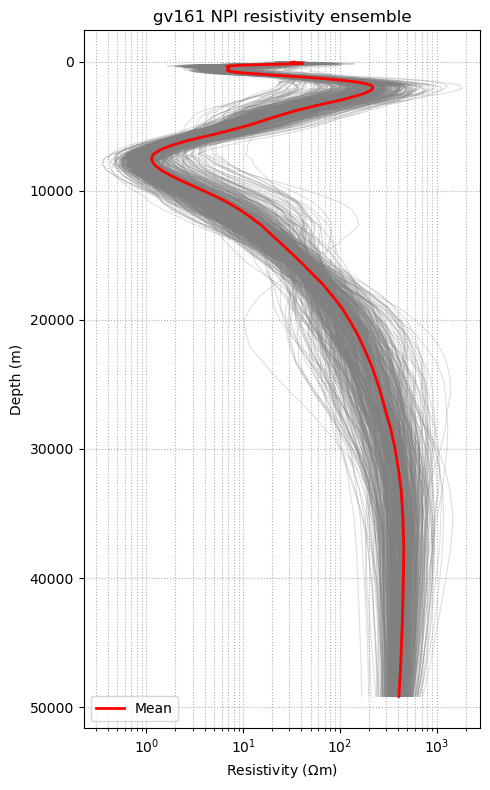

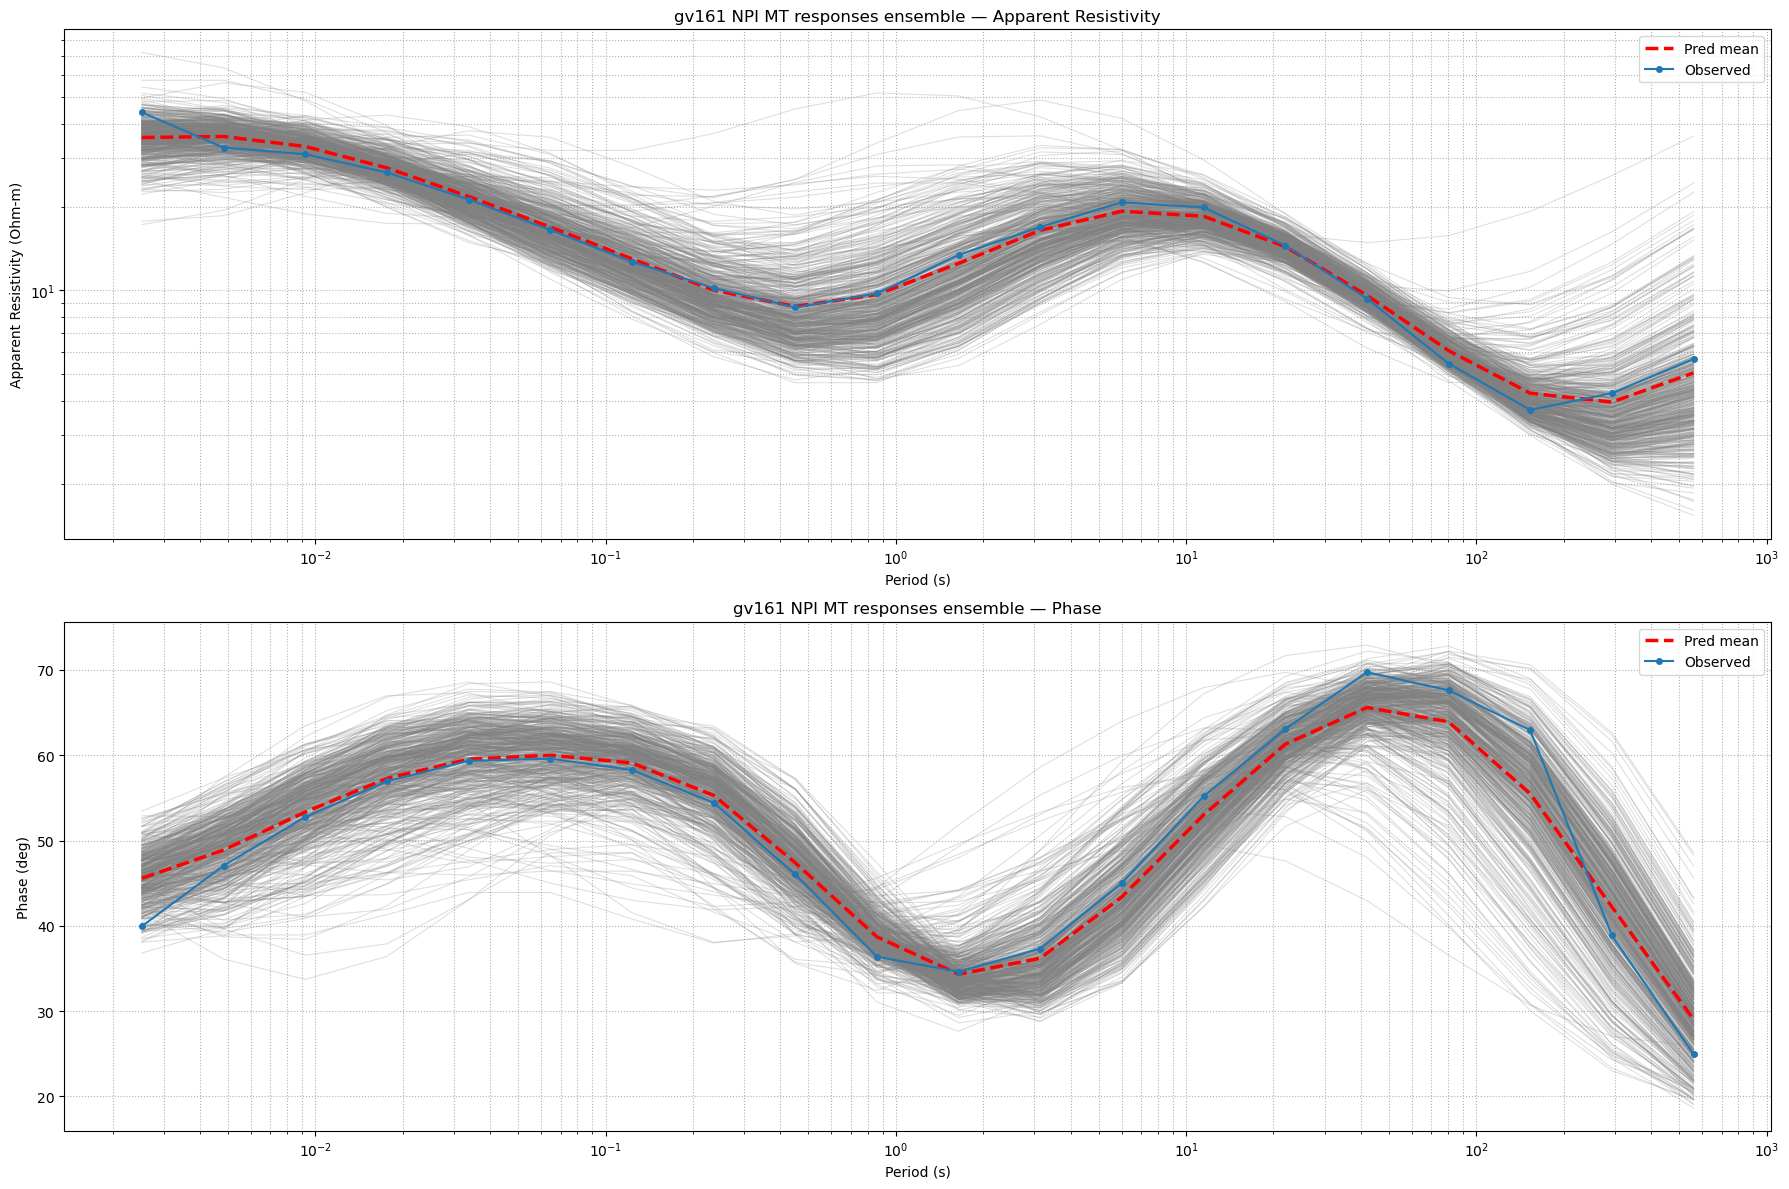

In [15]:
# --- Plot refined ensembles ---
plot_resistivity_ensemble(
    rho_refined_ens.T,
    depths_if_m,
    title='gv161 NPI resistivity ensemble',
    savepath=OUT_DIR  / 'posterior_resistivity.png'
)

plot_mt_ensemble(
    1/freqs_real_hz,
    appres_refined_ens.T,
    phase_refined_ens.T,
    app_obs_ohm_m,
    phi_obs_deg,
    title='gv161 NPI MT responses ensemble',
    savepath=OUT_DIR / 'posterior_mt_obs_band.png'
)